## Task

Figure out a flow/code to get an ap1D spectrum given a designation

How:

Assuming we have MJD, plate and fiber (from searchVisits)

download the apVisit file and extract the "FRAME[N]" header keyword - add a "0" to the front if it is 7 digits = NUM
The files to download (for DR14) would be 
https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/red/[MJD]/ap1D-[abc]-[NUM].fits 
a,b,c are the three spectra we want
We want to extract the [FIBER] row of the data; e.g., 
hdulist = fits.open(FILE)
flux = hdulist[1].data[FIBER]   etc. 


In [1]:
import numpy as np
import os
import glob
import apogee_tools as ap
from astropy.io import fits
import matplotlib.pyplot as plt
from apogee_tools import spec_tools, rotation_broaden, lsf
%matplotlib inline

In [2]:
def get_urls_from_header(path, frame_id):
    """
    This functions reads the header of a visit file
    and returns 1D-visit spectrum urls for different frames
    """
    #read visit spectrum header if local, obtain mjd and extract the "FRAME[N]" header keyword
    header=fits.open(path)[0].header
    
    frame_ids=None #frame ids are 1, 2, 3, ...
    frames=[] #strings : FRAM1, FRAME2, ...
    
    #option to obtain all the frames
    if frame_id =='all':
        #get all 12 frames
        frame_ids=['FRAME'+str(i) for i in np.arange(12)]

    #option to obtain one frame
    if isinstance(frame_id, int) and (frame_id !='all'):
        frame_ids=['FRAME'+str(frame_id)]
        
    #option to obtain specific frames
    if isinstance(frame_id, list):
        fram_ids=['FRAME'+str(i) for i in frame_id]
    
    #get frame ids, ignore key errors 
    for frame_id in frame_ids:
        try:
            frame=str(header[frame_id])
            #- add a "0" to the front if it is 7 digits = NUM
            if len(frame) ==7: frame='0'+frame
            frames.append(frame)
        except KeyError:
            continue 
    
    #get mjd
    mjd=header['MJD5']
    
    #format urls
    urls=[['https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/red/'+ str(mjd)+\
    '/ap1D-'+str(band)+'-'+str(frame)+'.fits' for band in ['a', 'b', 'c']] for frame in frames]
    
    return dict(zip(frame_ids, urls))

In [3]:
def get_1dspec_urls(apogee_id, **kwargs):
    """
    This function retrieves 1D visit spectra urls given an apogee id,
    a visit number (i.e, first visit, second visit etc.) and a frame id
    
    nvisit: should be an integer, default is 'all' or a list 
    frame_id: should be an integer, default is  'all'
    """
    #download visit spectrum
    ap.download(apogee_id, type='apvisit',  dir=os.environ['APOGEE_DATA']+'/apVisit_data/') #apogee_tools should not download if the file exists
    
    nvisit=kwargs.get('nvisit','all')
    frame_id=kwargs.get('frame_id', 'all')
    
    #initialize paths
    vis_spec_paths=None
    
    #if the user wants to obtain all the visit spectra
    if nvisit =='all':
        nvisit =''
        
    #if the user wants to obtain one visit spectrum
    if isinstance(nvisit, str) or isinstance(nvisit, int) and (nvisit !='all'):
        p=os.environ['APOGEE_DATA']+'/apVisit_data/apVisit-'+apogee_id+'-'+str(nvisit)+'*'+'.fits'
        vis_spec_paths=glob.glob(p)
    
    #if the user wants to obtain a specific list of visit spectra
    if isinstance(nvisit, list):
        ps=[os.environ['APOGEE_DATA']+'/apVisit_data/apVisit-'+apogee_id+'-'+str(vis)+'*'+'.fits'
            for vis in nvisit]
        vis_spec_paths=np.concatenate([glob.glob(p) for p in ps])
    
    #get formatted urls by reading each specific visit header file
    url_list=[get_urls_from_header(path, frame_id) for path in vis_spec_paths]
    
    #some formatting 
    visit_numbers=[x.split('.fits')[0].split('-')[-1] for x in vis_spec_paths]
    urls= {'visit'+visit: url for (visit, url) in zip(visit_numbers , url_list)}
    
    return urls

In [4]:
def download(url, destination):
    os.system("wget {} -P {}".format(str(url), str(destination)))
    return 

In [5]:
#usage 
urls=get_1dspec_urls('2M00452143+1634446', nvisit=2, frame_id=1)

In [6]:
urls

{'visit2': {'FRAME1': ['https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/red/56616/ap1D-a-10540039.fits',
   'https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/red/56616/ap1D-b-10540039.fits',
   'https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/red/56616/ap1D-c-10540039.fits']}}

In [7]:
abc=urls['visit2']['FRAME1']

In [8]:
index=1
fiber=1

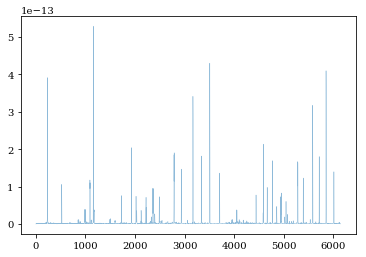

[ 3200.     5.     0.]
BTSETTLb: [3200, 5.0, 0.0]


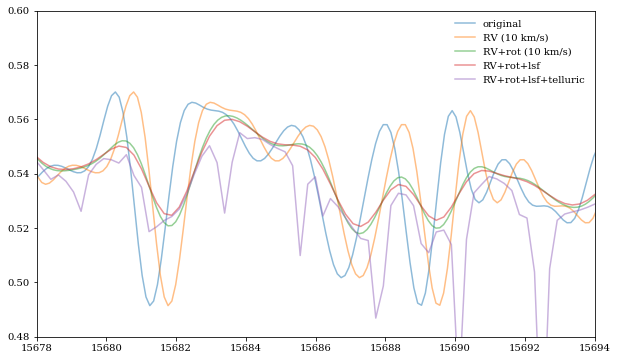

In [12]:
from astropy.utils.data import download_file
import apogee_tools.apogee_hack.spec.lsf as lsf
from apogee_tools.apogee_hack.spec.plot import apStarWavegrid
import pandas as pd
from apogee_tools import telluric

ChipA = download_file(abc[0], cache=False, show_progress=True)
ChipB = download_file(abc[1], cache=False, show_progress=True)
ChipC = download_file(abc[2], cache=False, show_progress=True)
hdulist  = fits.open(ChipA)
t1       = hdulist[index].data[fiber] # assuming the first extension is a table
hdulist  = fits.open(ChipB)
t2       = hdulist[index].data[fiber] # assuming the first extension is a table
hdulist  = fits.open(ChipC)
t3       = hdulist[index].data[fiber] # assuming the first extension is a table
y1 = t1*1e-17
y2 = t2*1e-17
y3 = t3*1e-17
plt.plot(np.concatenate([y1, y2, y3]), lw=0.5, alpha=0.5)
plt.show()


#### Need something here to pull a 1-d spectrum


### Work on the model
# Get a model
mdl      = ap.getModel(params=[3200, 5.0, 0.0], grid='BTSETTLb', xrange=[15200,16940])

# shift the RV
rv_wave  =  spec_tools._rvShift(mdl.wave, rv=10)

# Rotation broaden
newspec1 = rotation_broaden.broaden(rv_wave, mdl.flux, vbroad=10)

# Apply the LSF (This is borrowed from Jo Bovy's code)
fiber    = 40 # APOGEE Fiber. I just picked an APOGEE fiber. In principle this will come from the 1-d spectrum
xlsf     = np.linspace(-7.,7.,43)
lsf1     = lsf.eval(xlsf, fiber=fiber)
newspec2 = lsf.convolve(rv_wave, newspec1, xlsf=xlsf, lsf=lsf1, vmacro=None)
#telluric

newspec3 =telluric.applyTelluric(apStarWavegrid(), newspec2)



plt.figure(1, figsize=(10,6))
plt.plot(mdl.wave, mdl.flux, label='original', alpha=0.5)
plt.plot(rv_wave, mdl.flux, label='RV (10 km/s)', alpha=0.5)
plt.plot(rv_wave, newspec1, label='RV+rot (10 km/s)', alpha=0.5)
plt.plot(apStarWavegrid(), newspec2[0], label='RV+rot+lsf', alpha=0.5)
plt.plot(apStarWavegrid(), newspec3[0], label='RV+rot+lsf+telluric', alpha=0.5)
plt.xlim(15678, 15694)
plt.ylim(0.48, 0.60)
plt.legend(frameon=False)
#plt.savefig('Test.png', dpi=600)
plt.show()

In [ ]:
get_1dspec_urls('2M19213157+4317347', nvisit=1, frame_id=1)


In [ ]:
ap.Spectrum9()
newspec2